# 03 - Clasificacion de Eventos Sismicos Volcanicos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score,
    precision_recall_fscore_support
)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

PROJECT_ROOT = Path.cwd().parent
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

CLASS_NAMES = ['VT', 'LP', 'TC', 'TR', 'HY']
N_CLASSES = 5


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [ ]:

baseline = np.load(PROCESSED_DIR / 'baseline_features.npz', allow_pickle=True)
X_train_feat = baseline['X_train']
X_val_feat = baseline['X_val']
X_test_feat = baseline['X_test']

X_trainval_feat = np.vstack([X_train_feat, X_val_feat])
y_trainval = np.concatenate([baseline['y_train'], baseline['y_val']])
y_test_bl = baseline['y_test']


seq = np.load(PROCESSED_DIR / 'sequences_fixed_length.npz')
X_train_seq = seq['X_train']
X_val_seq = seq['X_val']
X_test_seq = seq['X_test']
y_train = seq['y_train']
y_val = seq['y_val']
y_test = seq['y_test']

INPUT_LENGTH = X_train_seq.shape[1]
N_FEATURES = X_train_feat.shape[1]

print(f"Secuencias: {X_train_seq.shape}, Features: {X_train_feat.shape}")
print(f"Distribucion clases train: {np.bincount(y_train)}")
print(f"Distribucion clases test: {np.bincount(y_test)}")


class_weights = {i: len(y_train) / (N_CLASSES * np.sum(y_train == i)) for i in range(N_CLASSES)}
print(f"\nPesos de clase: {class_weights}")

Secuencias: (4301, 4000, 1), Features: (4301, 27)
Distribucion clases train: [1880  404 1538  330  149]
Distribucion clases test: [403  87 330  70  32]

Pesos de clase: {0: 0.4575531914893617, 1: 2.129207920792079, 2: 0.5592977893368011, 3: 2.6066666666666665, 4: 5.773154362416108}


## Seccion 6: Modelo Baseline (Random Forest)


In [4]:
rf = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
rf.fit(X_trainval_feat, y_trainval)
y_pred_rf = rf.predict(X_test_feat)

print("="*60)
print("RANDOM FOREST (BASELINE)")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test_bl, y_pred_rf):.4f}")
print(f"F1 Macro: {f1_score(y_test_bl, y_pred_rf, average='macro'):.4f}")
print(f"F1 Weighted: {f1_score(y_test_bl, y_pred_rf, average='weighted'):.4f}")
print("\n" + classification_report(y_test_bl, y_pred_rf, target_names=CLASS_NAMES))

RANDOM FOREST (BASELINE)
Accuracy: 0.7386
F1 Macro: 0.4568
F1 Weighted: 0.7019

              precision    recall  f1-score   support

          VT       0.84      0.91      0.87       403
          LP       0.69      0.43      0.52        87
          TC       0.66      0.83      0.73       330
          TR       0.27      0.06      0.09        70
          HY       1.00      0.03      0.06        32

    accuracy                           0.74       922
   macro avg       0.69      0.45      0.46       922
weighted avg       0.72      0.74      0.70       922



## Seccion 7: Modelo CNN-GRU con Fusion

In [ ]:
def build_model(input_length, n_features, n_classes, filters=16, gru_units=32, kernel_size=7):
    
    input_signal = Input(shape=(input_length, 1), name='signal')
    input_features = Input(shape=(n_features,), name='features')
    
    
    x = Conv1D(filters, kernel_size, activation='relu', padding='same')(input_signal)
    x = BatchNormalization()(x)
    x = MaxPooling1D(5)(x)  
    
    x = Conv1D(filters*2, kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(5)(x)  
    
    x = GRU(gru_units)(x)
    x = Dropout(0.3)(x)
    signal_out = Dense(16, activation='relu')(x)
    
    
    f = Dense(32, activation='relu')(input_features)
    f = Dropout(0.3)(f)
    feat_out = Dense(16, activation='relu')(f)
    
    
    combined = Concatenate()([signal_out, feat_out])
    combined = Dense(32, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(n_classes, activation='softmax')(combined)
    
    return Model(inputs=[input_signal, input_features], outputs=output)

model = build_model(INPUT_LENGTH, N_FEATURES, N_CLASSES)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 4000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4000, 16)     128         ['signal[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 4000, 16)    64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 800, 16)      0           ['batch_normalization[0][0]']

In [ ]:

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


history = model.fit(
    [X_train_seq, X_train_feat],
    y_train,
    validation_data=([X_val_seq, X_val_feat], y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
135/135 [==============================] - 11s 26ms/step - loss: 1.5751 - accuracy: 0.2827 - val_loss: 1.4769 - val_accuracy: 0.4046 - lr: 0.0010
Epoch 2/100
135/135 [==============================] - 3s 21ms/step - loss: 1.4363 - accuracy: 0.4032 - val_loss: 1.3412 - val_accuracy: 0.4642 - lr: 0.0010
Epoch 3/100
135/135 [==============================] - 3s 21ms/step - loss: 1.3811 - accuracy: 0.4278 - val_loss: 1.2431 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
135/135 [==============================] - 3s 21ms/step - loss: 1.2950 - accuracy: 0.4845 - val_loss: 1.1951 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 5/100
135/135 [==============================] - 3s 21ms/step - loss: 1.2538 - accuracy: 0.4843 - val_loss: 1.1244 - val_accuracy: 0.5282 - lr: 0.0010
Epoch 6/100
135/135 [==============================] - 3s 22ms/step - loss: 1.2367 - accuracy: 0.4920 - val_loss: 1.0196 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 7/100
135/135 [==============================] - 3s

In [ ]:

y_pred_proba = model.predict([X_test_seq, X_test_feat], verbose=0)
y_pred_dl = np.argmax(y_pred_proba, axis=1)

print("="*60)
print("CNN-GRU FUSION")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dl):.4f}")
print(f"F1 Macro: {f1_score(y_test, y_pred_dl, average='macro'):.4f}")
print(f"F1 Weighted: {f1_score(y_test, y_pred_dl, average='weighted'):.4f}")
print("\n" + classification_report(y_test, y_pred_dl, target_names=CLASS_NAMES))

CNN-GRU FUSION
Accuracy: 0.5466
F1 Macro: 0.4332
F1 Weighted: 0.5350

              precision    recall  f1-score   support

          VT       0.85      0.80      0.83       403
          LP       0.31      0.86      0.46        87
          TC       0.82      0.16      0.27       330
          TR       0.21      0.57      0.31        70
          HY       0.26      0.38      0.30        32

    accuracy                           0.55       922
   macro avg       0.49      0.55      0.43       922
weighted avg       0.72      0.55      0.53       922



## Seccion 8: Analisis de Robustez y Sensibilidad

In [8]:
def quick_train(model):
    """Entrena y evalua modelo rapidamente"""
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit([X_train_seq, X_train_feat], y_train,
              validation_data=([X_val_seq, X_val_feat], y_val),
              epochs=60, batch_size=32, class_weight=class_weights,
              callbacks=[EarlyStopping(patience=15, restore_best_weights=True)], verbose=0)
    y_pred = np.argmax(model.predict([X_test_seq, X_test_feat], verbose=0), axis=1)
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')

In [ ]:
def build_model_variable_depth(input_length, n_features, n_classes, n_conv_layers=2, filters=16, gru_units=32):
    """Modelo con profundidad variable"""
    input_signal = Input(shape=(input_length, 1), name='signal')
    input_features = Input(shape=(n_features,), name='features')
    
    
    x = input_signal
    current_filters = filters
    
    for i in range(n_conv_layers):
        x = Conv1D(current_filters, 7, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(5)(x)
        current_filters *= 2
    
    x = GRU(gru_units)(x)
    x = Dropout(0.3)(x)
    signal_out = Dense(16, activation='relu')(x)
    
    
    f = Dense(32, activation='relu')(input_features)
    f = Dropout(0.3)(f)
    feat_out = Dense(16, activation='relu')(f)
    
    
    combined = Concatenate()([signal_out, feat_out])
    combined = Dense(32, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(n_classes, activation='softmax')(combined)
    
    return Model(inputs=[input_signal, input_features], outputs=output)

In [ ]:
results = []


print("Variando filtros...")
for f in [8, 16, 32, 64]:
    acc, f1 = quick_train(build_model(INPUT_LENGTH, N_FEATURES, N_CLASSES, filters=f))
    results.append({'Param': 'Filtros', 'Valor': f, 'Acc': acc, 'F1': f1})
    print(f"  {f} filtros: Acc={acc:.4f}, F1={f1:.4f}")


print("\nVariando GRU...")
for g in [16, 32, 64, 128]:
    acc, f1 = quick_train(build_model(INPUT_LENGTH, N_FEATURES, N_CLASSES, gru_units=g))
    results.append({'Param': 'GRU', 'Valor': g, 'Acc': acc, 'F1': f1})
    print(f"  {g} GRU: Acc={acc:.4f}, F1={f1:.4f}")


print("\nVariando tamaño de kernel...")
for k in [3, 5, 7, 11]:
    acc, f1 = quick_train(build_model(INPUT_LENGTH, N_FEATURES, N_CLASSES, kernel_size=k))
    results.append({'Param': 'Kernel', 'Valor': k, 'Acc': acc, 'F1': f1})
    print(f"  Kernel {k}: Acc={acc:.4f}, F1={f1:.4f}")


print("\nVariando profundidad (capas CNN)...")
for n_layers in [1, 2, 3]:
    acc, f1 = quick_train(build_model_variable_depth(INPUT_LENGTH, N_FEATURES, N_CLASSES, n_conv_layers=n_layers))
    results.append({'Param': 'Profundidad', 'Valor': n_layers, 'Acc': acc, 'F1': f1})
    print(f"  {n_layers} capas CNN: Acc={acc:.4f}, F1={f1:.4f}")

df_robust = pd.DataFrame(results)
print("\nResumen:")
print(df_robust.to_string(index=False))

Variando filtros...
  8 filtros: Acc=0.5466, F1=0.4304
  16 filtros: Acc=0.5889, F1=0.4685
  32 filtros: Acc=0.5998, F1=0.4755
  64 filtros: Acc=0.5401, F1=0.4232

Variando GRU...
  16 GRU: Acc=0.5954, F1=0.4685
  32 GRU: Acc=0.5683, F1=0.4583
  64 GRU: Acc=0.5792, F1=0.4625
  128 GRU: Acc=0.5835, F1=0.4521

Variando tamaño de kernel...
  Kernel 3: Acc=0.6139, F1=0.4922
  Kernel 5: Acc=0.5813, F1=0.4387
  Kernel 7: Acc=0.5629, F1=0.4478
  Kernel 11: Acc=0.5933, F1=0.4571

Variando profundidad (capas CNN)...
  1 capas CNN: Acc=0.5705, F1=0.4580
  2 capas CNN: Acc=0.5499, F1=0.4220
  3 capas CNN: Acc=0.5412, F1=0.4316

Resumen:
      Param  Valor      Acc       F1
    Filtros      8 0.546638 0.430351
    Filtros     16 0.588937 0.468489
    Filtros     32 0.599783 0.475539
    Filtros     64 0.540130 0.423201
        GRU     16 0.595445 0.468462
        GRU     32 0.568330 0.458284
        GRU     64 0.579176 0.462509
        GRU    128 0.583514 0.452122
     Kernel      3 0.613883 0.492

In [ ]:

print("\n" + "="*60)
print("ANALISIS DE ESTABILIDAD (Coeficiente de Variacion)")
print("="*60)

stability_results = []
for param in ['Filtros', 'GRU', 'Kernel', 'Profundidad']:
    subset = df_robust[df_robust['Param'] == param]
    mean_f1 = subset['F1'].mean()
    std_f1 = subset['F1'].std()
    cv = (std_f1 / mean_f1) * 100  
    
    stability_results.append({
        'Parametro': param,
        'Media F1': mean_f1,
        'Std F1': std_f1,
        'CV (%)': cv
    })
    
    print(f"{param:15s}: Media F1={mean_f1:.4f}, Std={std_f1:.4f}, CV={cv:.2f}%")
    
    if cv < 2:
        print(f"  → Muy robusto (baja sensibilidad)")
    elif cv < 5:
        print(f"  → Robusto")
    elif cv < 10:
        print(f"  → Moderadamente sensible")
    else:
        print(f"  → Altamente sensible")

df_stability = pd.DataFrame(stability_results)


most_stable = df_stability.loc[df_stability['CV (%)'].idxmin()]
print(f"\n→ Parametro mas robusto: {most_stable['Parametro']} (CV = {most_stable['CV (%)']:.2f}%)")


best_config = df_robust.loc[df_robust['F1'].idxmax()]
print(f"→ Mejor configuracion: {best_config['Param']} = {best_config['Valor']} (F1 = {best_config['F1']:.4f})")


ANALISIS DE ESTABILIDAD (Coeficiente de Variacion)
Filtros        : Media F1=0.4494, Std=0.0264, CV=5.88%
  → Moderadamente sensible
GRU            : Media F1=0.4603, Std=0.0069, CV=1.50%
  → Muy robusto (baja sensibilidad)
Kernel         : Media F1=0.4589, Std=0.0234, CV=5.10%
  → Moderadamente sensible
Profundidad    : Media F1=0.4372, Std=0.0186, CV=4.26%
  → Robusto

→ Parametro mas robusto: GRU (CV = 1.50%)
→ Mejor configuracion: Kernel = 3 (F1 = 0.4922)


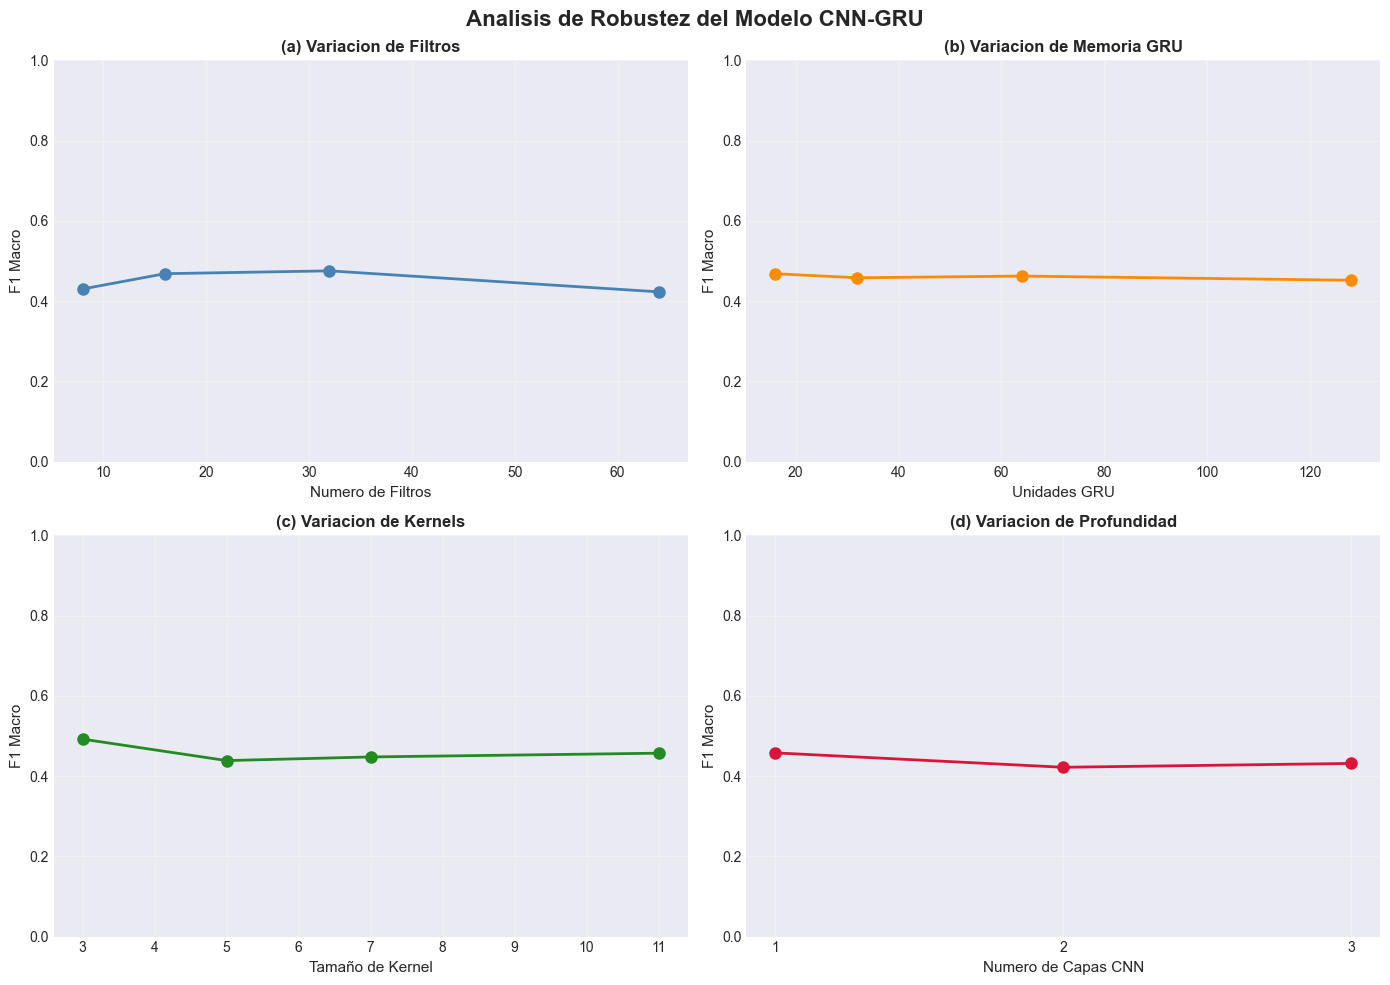

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Analisis de Robustez del Modelo CNN-GRU', fontsize=16, fontweight='bold')


ax = axes[0, 0]
subset = df_robust[df_robust['Param'] == 'Filtros']
ax.plot(subset['Valor'], subset['F1'], 'o-', linewidth=2, markersize=8, color='steelblue')
ax.set_xlabel('Numero de Filtros', fontsize=11)
ax.set_ylabel('F1 Macro', fontsize=11)
ax.set_title('(a) Variacion de Filtros', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])


ax = axes[0, 1]
subset = df_robust[df_robust['Param'] == 'GRU']
ax.plot(subset['Valor'], subset['F1'], 'o-', linewidth=2, markersize=8, color='darkorange')
ax.set_xlabel('Unidades GRU', fontsize=11)
ax.set_ylabel('F1 Macro', fontsize=11)
ax.set_title('(b) Variacion de Memoria GRU', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])


ax = axes[1, 0]
subset = df_robust[df_robust['Param'] == 'Kernel']
ax.plot(subset['Valor'], subset['F1'], 'o-', linewidth=2, markersize=8, color='forestgreen')
ax.set_xlabel('Tamaño de Kernel', fontsize=11)
ax.set_ylabel('F1 Macro', fontsize=11)
ax.set_title('(c) Variacion de Kernels', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])


ax = axes[1, 1]
subset = df_robust[df_robust['Param'] == 'Profundidad']
ax.plot(subset['Valor'], subset['F1'], 'o-', linewidth=2, markersize=8, color='crimson')
ax.set_xlabel('Numero de Capas CNN', fontsize=11)
ax.set_ylabel('F1 Macro', fontsize=11)
ax.set_title('(d) Variacion de Profundidad', fontsize=12, fontweight='bold')
ax.set_xticks([1, 2, 3])
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'robustez_completo.png', dpi=300, bbox_inches='tight')
plt.show()

## Seccion 9: Evaluacion y Metricas

In [ ]:

prec_rf, rec_rf, f1_rf, support_rf = precision_recall_fscore_support(
    y_test_bl, y_pred_rf, labels=range(N_CLASSES)
)
prec_dl, rec_dl, f1_dl, support_dl = precision_recall_fscore_support(
    y_test, y_pred_dl, labels=range(N_CLASSES)
)


comparison_data = []
for i, cls in enumerate(CLASS_NAMES):
    comparison_data.append({
        'Clase': cls,
        'Soporte': support_rf[i],
        'Precision_RF': prec_rf[i],
        'Recall_RF': rec_rf[i],
        'F1_RF': f1_rf[i],
        'Precision_DL': prec_dl[i],
        'Recall_DL': rec_dl[i],
        'F1_DL': f1_dl[i]
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison['Delta_F1'] = df_comparison['F1_DL'] - df_comparison['F1_RF']

print("="*100)
print("COMPARACION DETALLADA POR CLASE")
print("="*100)
print(df_comparison.to_string(index=False))

print("\n" + "="*60)
print("MEJORAS/EMPEORAMIENTOS: CNN-GRU vs RANDOM FOREST")
print("="*60)
print(df_comparison[['Clase', 'Soporte', 'Delta_F1']].to_string(index=False))


print("\n" + "="*60)
print("INTERPRETACION")
print("="*60)
for _, row in df_comparison.iterrows():
    cls = row['Clase']
    delta_f1 = row['Delta_F1']
    if delta_f1 > 0.05:
        print(f"{cls}: Mejora significativa de CNN-GRU (+{delta_f1:.3f})")
    elif delta_f1 < -0.05:
        print(f"{cls}: Random Forest superior ({delta_f1:.3f})")
    else:
        print(f"{cls}: Desempeño similar entre modelos ({delta_f1:+.3f})")

COMPARACION DETALLADA POR CLASE
Clase  Soporte  Precision_RF  Recall_RF    F1_RF  Precision_DL  Recall_DL    F1_DL  Delta_F1
   VT      403      0.835616   0.908189 0.870392      0.852632   0.803970 0.827586 -0.042806
   LP       87      0.685185   0.425287 0.524823      0.312500   0.862069 0.458716 -0.066107
   TC      330      0.659420   0.827273 0.733871      0.815385   0.160606 0.268354 -0.465517
   TR       70      0.266667   0.057143 0.094118      0.210526   0.571429 0.307692  0.213575
   HY       32      1.000000   0.031250 0.060606      0.255319   0.375000 0.303797  0.243191

MEJORAS/EMPEORAMIENTOS: CNN-GRU vs RANDOM FOREST
Clase  Soporte  Delta_F1
   VT      403 -0.042806
   LP       87 -0.066107
   TC      330 -0.465517
   TR       70  0.213575
   HY       32  0.243191

INTERPRETACION
VT: Desempeño similar entre modelos (-0.043)
LP: Random Forest superior (-0.066)
TC: Random Forest superior (-0.466)
TR: Mejora significativa de CNN-GRU (+0.214)
HY: Mejora significativa de CNN-

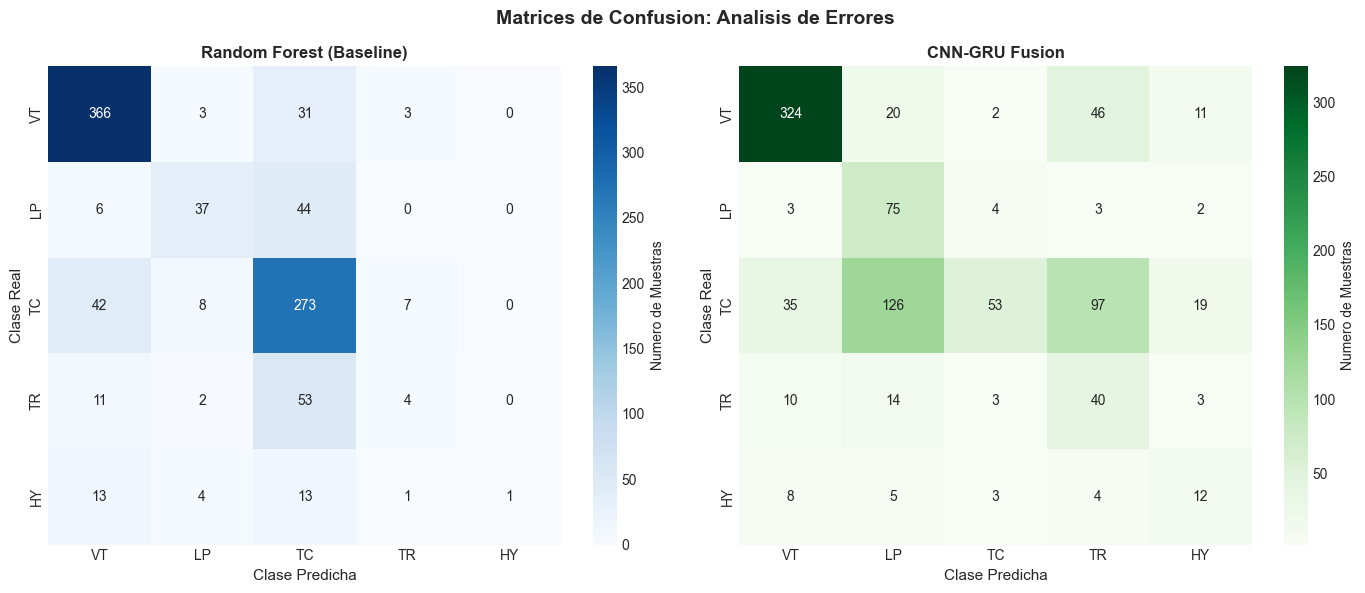


ANALISIS DE ERRORES MAS COMUNES

Confusion mas frecuente (CNN-GRU):
  TC confundido con LP: 126 veces

Top 3 confusiones:
  TC → LP: 126 errores
  TC → TR: 97 errores
  VT → TR: 46 errores


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Matrices de Confusion: Analisis de Errores', fontsize=14, fontweight='bold')


cm_rf = confusion_matrix(y_test_bl, y_pred_rf)
sns.heatmap(
    cm_rf, annot=True, fmt='d', cmap='Blues',
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
    ax=axes[0], cbar_kws={'label': 'Numero de Muestras'}
)
axes[0].set_xlabel('Clase Predicha', fontsize=11)
axes[0].set_ylabel('Clase Real', fontsize=11)
axes[0].set_title('Random Forest (Baseline)', fontsize=12, fontweight='bold')


cm_dl = confusion_matrix(y_test, y_pred_dl)
sns.heatmap(
    cm_dl, annot=True, fmt='d', cmap='Greens',
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
    ax=axes[1], cbar_kws={'label': 'Numero de Muestras'}
)
axes[1].set_xlabel('Clase Predicha', fontsize=11)
axes[1].set_ylabel('Clase Real', fontsize=11)
axes[1].set_title('CNN-GRU Fusion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*60)
print("ANALISIS DE ERRORES MAS COMUNES")
print("="*60)

cm_dl_copy = cm_dl.copy()
np.fill_diagonal(cm_dl_copy, 0)
max_conf = np.unravel_index(cm_dl_copy.argmax(), cm_dl_copy.shape)
print(f"\nConfusion mas frecuente (CNN-GRU):")
print(f"  {CLASS_NAMES[max_conf[0]]} confundido con {CLASS_NAMES[max_conf[1]]}: {cm_dl_copy[max_conf]} veces")


flat_idx = np.argsort(cm_dl_copy.ravel())[::-1]
print(f"\nTop 3 confusiones:")
for idx in flat_idx[:3]:
    i, j = np.unravel_index(idx, cm_dl_copy.shape)
    if cm_dl_copy[i, j] > 0:
        print(f"  {CLASS_NAMES[i]} → {CLASS_NAMES[j]}: {cm_dl_copy[i, j]} errores")

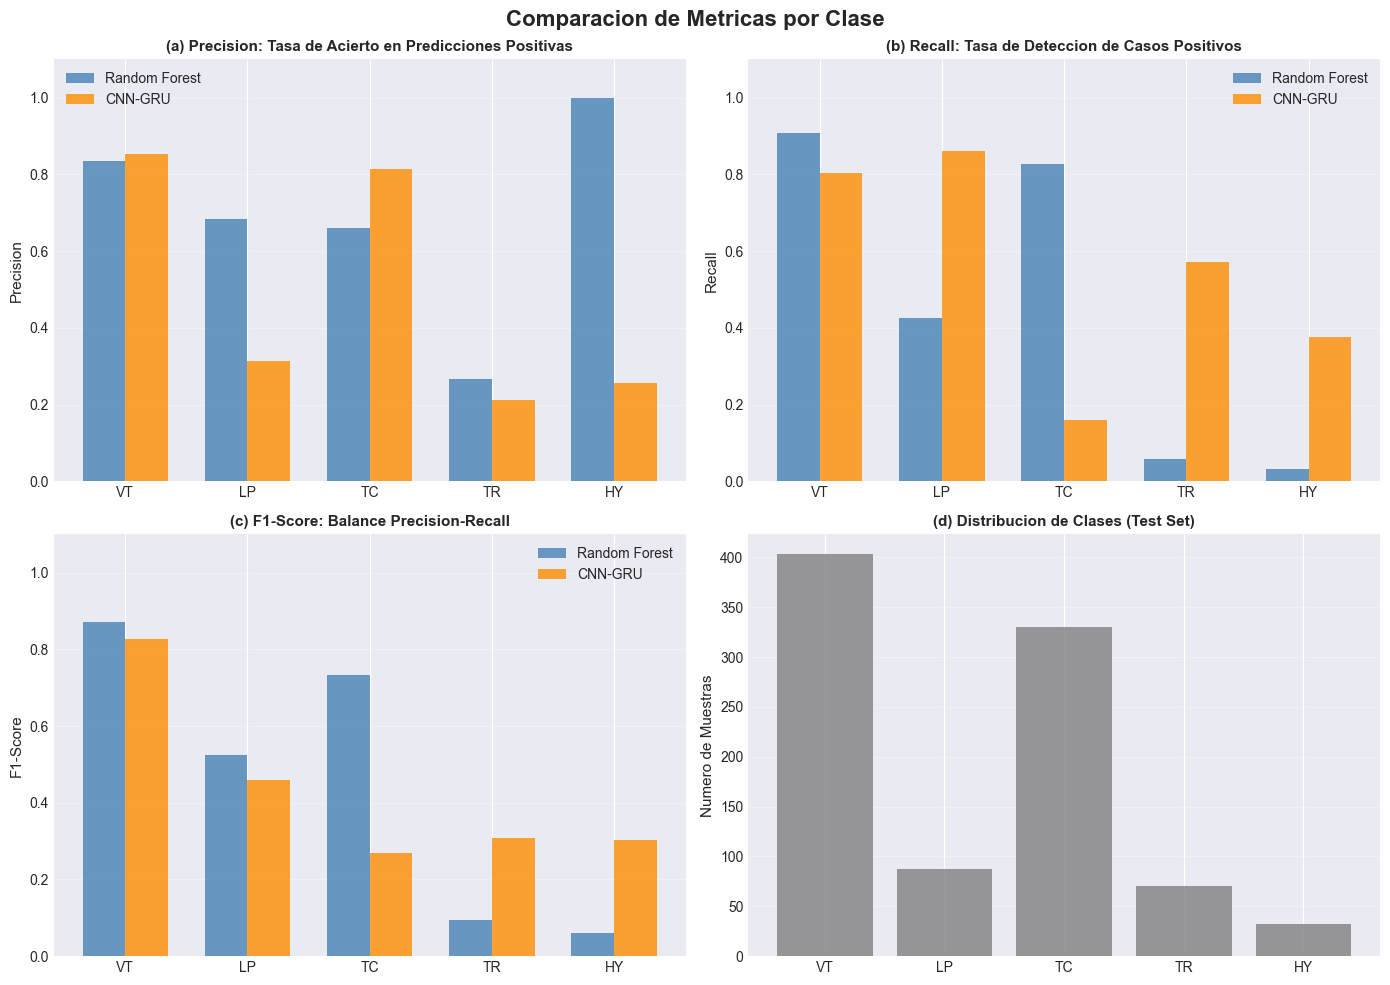

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparacion de Metricas por Clase', fontsize=16, fontweight='bold')

x = np.arange(len(CLASS_NAMES))
width = 0.35


ax = axes[0, 0]
bars1 = ax.bar(x - width/2, prec_rf, width, label='Random Forest', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, prec_dl, width, label='CNN-GRU', alpha=0.8, color='darkorange')
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('(a) Precision: Tasa de Acierto en Predicciones Positivas', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])


ax = axes[0, 1]
bars1 = ax.bar(x - width/2, rec_rf, width, label='Random Forest', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, rec_dl, width, label='CNN-GRU', alpha=0.8, color='darkorange')
ax.set_ylabel('Recall', fontsize=11)
ax.set_title('(b) Recall: Tasa de Deteccion de Casos Positivos', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])


ax = axes[1, 0]
bars1 = ax.bar(x - width/2, f1_rf, width, label='Random Forest', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, f1_dl, width, label='CNN-GRU', alpha=0.8, color='darkorange')
ax.set_ylabel('F1-Score', fontsize=11)
ax.set_title('(c) F1-Score: Balance Precision-Recall', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])


ax = axes[1, 1]
ax.bar(x, support_rf, alpha=0.8, color='gray')
ax.set_ylabel('Numero de Muestras', fontsize=11)
ax.set_title('(d) Distribucion de Clases (Test Set)', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'metricas_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

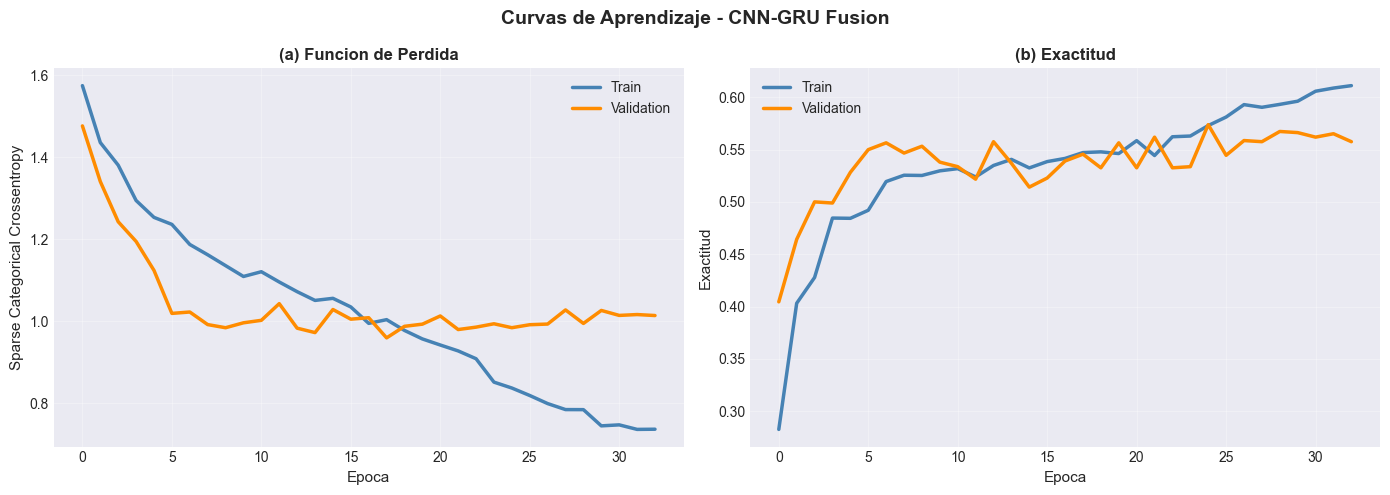


ANALISIS DE CONVERGENCIA
Numero total de epocas: 33
Mejor epoch (val_loss): 18
Loss final (train): 0.7371
Loss final (val): 1.0144
Accuracy final (train): 0.6110
Accuracy final (val): 0.5575

✓ Gap train-val aceptable (gap = 0.054)


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Curvas de Aprendizaje - CNN-GRU Fusion', fontsize=14, fontweight='bold')


axes[0].plot(history.history['loss'], label='Train', linewidth=2.5, color='steelblue')
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2.5, color='darkorange')
axes[0].set_xlabel('Epoca', fontsize=11)
axes[0].set_ylabel('Sparse Categorical Crossentropy', fontsize=11)
axes[0].set_title('(a) Funcion de Perdida', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)


axes[1].plot(history.history['accuracy'], label='Train', linewidth=2.5, color='steelblue')
axes[1].plot(history.history['val_accuracy'], label='Validation', linewidth=2.5, color='darkorange')
axes[1].set_xlabel('Epoca', fontsize=11)
axes[1].set_ylabel('Exactitud', fontsize=11)
axes[1].set_title('(b) Exactitud', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*60)
print("ANALISIS DE CONVERGENCIA")
print("="*60)
print(f"Numero total de epocas: {len(history.history['loss'])}")
print(f"Mejor epoch (val_loss): {np.argmin(history.history['val_loss']) + 1}")
print(f"Loss final (train): {history.history['loss'][-1]:.4f}")
print(f"Loss final (val): {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy final (train): {history.history['accuracy'][-1]:.4f}")
print(f"Accuracy final (val): {history.history['val_accuracy'][-1]:.4f}")

gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
if gap > 0.1:
    print(f"\n⚠ ADVERTENCIA: Posible overfitting detectado (gap = {gap:.3f})")
elif gap > 0.05:
    print(f"\n✓ Gap train-val aceptable (gap = {gap:.3f})")
else:
    print(f"\n✓ Buen balance train-val (gap = {gap:.3f})")